In [7]:
import pandas as pd
import numpy as np
import os
import sys
from random import randrange
import scipy
from datetime import datetime
from keras.callbacks import EarlyStopping

import librosa # For analyzing audio and music, extracting the data from the audio files
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

from IPython.display import Audio # To play the audio files

import keras
from keras.models import Sequential
from tensorflow.keras import layers, models, callbacks, regularizers

from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import concurrent.futures
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
import pickle
import json
import warnings
warnings.filterwarnings('ignore')
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
data_df=pd.read_csv(r"speechDataSet.csv")

In [9]:
# Checking label counts
data_df.Emotions.value_counts()

Emotions
happy       1923
sad         1923
angry       1923
fear        1923
disgust     1922
neutral     1703
surprise     652
calm         192
Name: count, dtype: int64

Might Drop surprise and calm for having low number of samples

nutral and calm are similer and they will be combined

In [10]:
# Combining neutral and calm instances
data_df.loc[data_df['Emotions'] == 'neutral','Emotions'] = "calm"

In [11]:
# Assuming your DataFrame is named df and the emotion column is named 'emotion'
data_df = data_df[data_df['Emotions'] != 'surprise']
data_df.Emotions.value_counts()


Emotions
happy      1923
sad        1923
angry      1923
fear       1923
disgust    1922
calm       1895
Name: count, dtype: int64

In [15]:
# Drop null values
print(data_df.isnull().sum())
data_df.dropna(inplace=True)
print(f"Null values in dataframe: {sum(data_df.isnull().sum())}")
print(f"Shape of dataframe: {data_df.shape}")

Emotions    0
Path        0
dtype: int64
Null values in dataframe: 0
Shape of dataframe: (11509, 2)


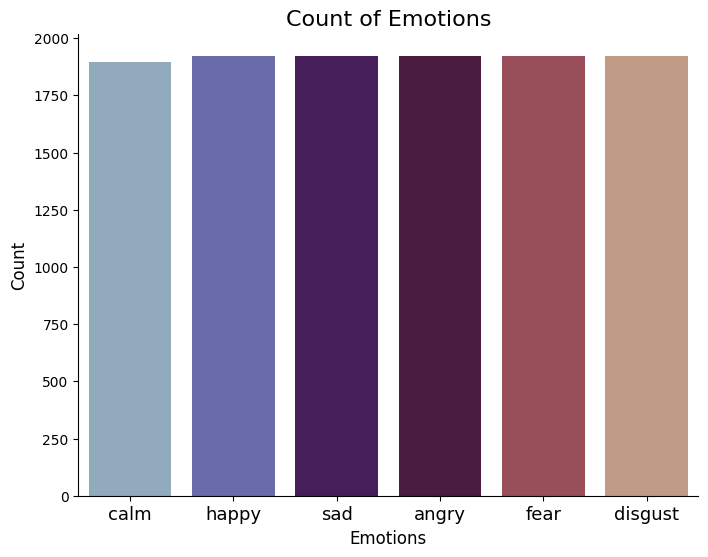

In [13]:
# Plot to see counts of labels
plt.figure(figsize=(8 ,6))
plt.title('Count of Emotions', size=16)
# Google drive plot
sns.countplot(data=data_df, x="Emotions", hue="Emotions", palette="twilight", legend=False)
# Kaggle plot
# sns.countplot(data=data_df, x="Emotions")
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tick_params(axis='x', labelsize=13)
plt.show()

In [476]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11509 entries, 0 to 464
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotions  11509 non-null  object
 1   Path      11509 non-null  object
dtypes: object(2)
memory usage: 269.7+ KB


In [16]:
# Function to plot waveform
def create_waveplot(data, sr, emo):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {emo} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel('Time(s)', size=12)
    plt.ylabel('Amplitude', size=12)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.show()

# Function to plot spectrogram
def create_spectrogram(data, sr, emo):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    # Convert frequency into decibels
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(11, 3))
    plt.title(f'Spectrogram for audio with {emo} emotion', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.xlabel('Time(s)', size=12)
    plt.ylabel('Hz', size=12)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.colorbar()

# Combine all plot functions
def combine_plots(data, emo):
    # Randomly select data instance of given emotion
    data_path = data[data['Emotions'] == emo]['Path'].iloc[randrange(len(data[data['Emotions'] == emo]))]
    data, sr = librosa.load(data_path)
    create_waveplot(data, sr, emo)
    create_spectrogram(data, sr, emo)
    return data, sr

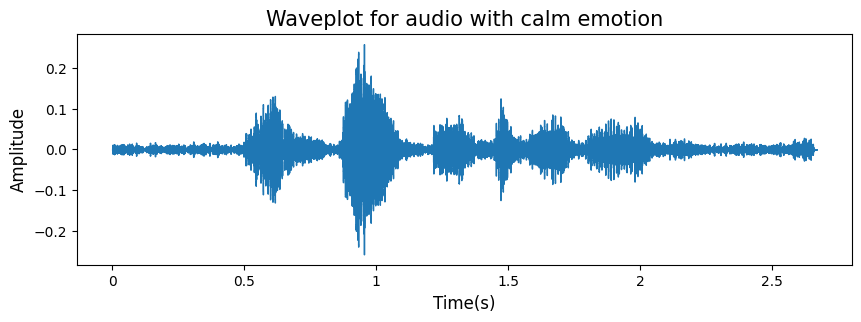

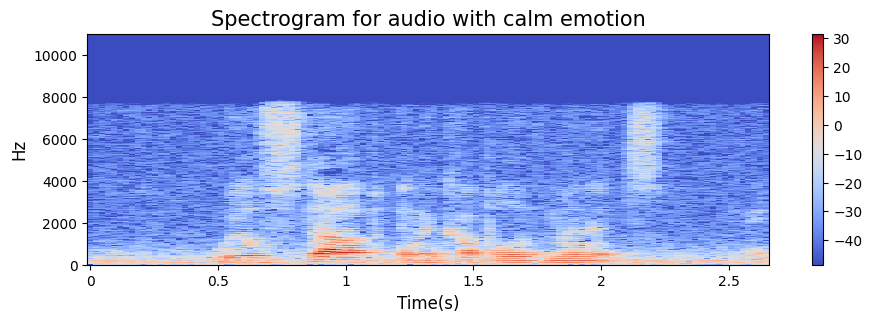

In [17]:
emo = 'calm'
data, sr = combine_plots(data_df, emo)
Audio(data, rate=sr)

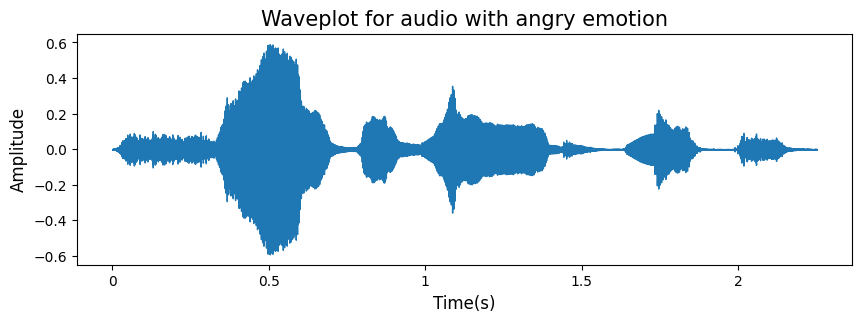

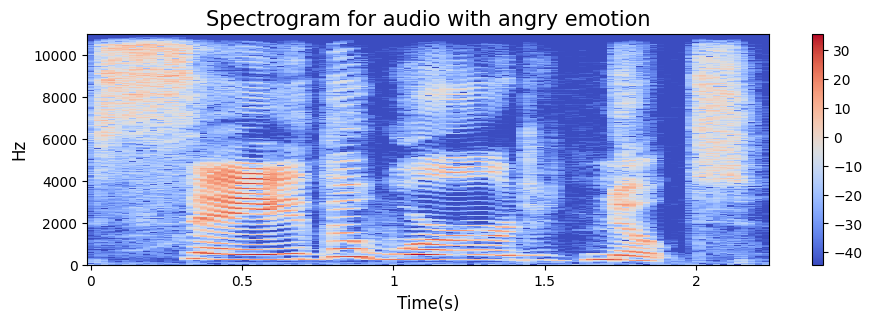

In [18]:
emo = "angry"
data, sr = combine_plots(data_df, emo)
Audio(data, rate=sr)

In [19]:
# Function to introduce noise in the audio
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data
# Function to stretch audio
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

# Function to change the pitch of the data
def pitch(data, sample_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=pitch_factor)

In [20]:
# Function to extract features
def extract_features(data, sample_rate):
    # MFCCs
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)

    # Energy
    energy = np.mean(librosa.feature.rms(y=data).T, axis=0)

    # Entropy of energy (computed as entropy of the short-term energy)
    st_energy = librosa.feature.rms(y=data, frame_length=2048, hop_length=512)
    entropy_of_energy = np.mean([scipy.stats.entropy(e) for e in st_energy])

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)

    # Mel-Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)

    # Spectral Centroid
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)

    # Spectral Spread
    spectral_spread = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)

    # Spectral Roll-off
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)

    # Concatenate all features
    features = np.hstack((mfcc, energy, entropy_of_energy, zcr, mel, spectral_centroid, spectral_spread, spectral_rolloff))
    return features

# Function to apply extract_features on data
def get_features(path):
  data, sample_rate = librosa.load(path, duration=3, offset=0.3)

  # Simple Audio
  simple = extract_features(data, sample_rate)

  # Noisy audio
  noisy = extract_features(noise(data), sample_rate)

  # Stretching
  stretched = extract_features(stretch(data), sample_rate)

  # Pitch shifting
  pitch_shifted = extract_features(pitch(data, sample_rate), sample_rate)

  # Concatenate
  features = np.vstack((simple, noisy, stretched, pitch_shifted))
  return features

In [21]:
def process_file(path, emotion):
    features = get_features(path)
    return [(feature, emotion) for feature in features]
X, y = [], []
c = 0
# Use ThreadPoolExecutor for I/O bound tasks or ProcessPoolExecutor for CPU bound tasks
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Create a list of futures
    futures = [executor.submit(process_file, path, emotion) for path, emotion in zip(data_df.Path, data_df.Emotions)]

    # As each future completes, process the results
    for future in concurrent.futures.as_completed(futures):
        results = future.result()
        for feature, emotion in results:
            X.append(feature)
            y.append(emotion)
            c += 1
        print(f"Processed {c} files")

Processed 4 files
Processed 8 files
Processed 12 files
Processed 16 files
Processed 20 files
Processed 24 files
Processed 28 files
Processed 32 files
Processed 36 files
Processed 40 files
Processed 44 files
Processed 48 files
Processed 52 files
Processed 56 files
Processed 60 files
Processed 64 files
Processed 68 files
Processed 72 files
Processed 76 files
Processed 80 files
Processed 84 files
Processed 88 files
Processed 92 files
Processed 96 files
Processed 100 files
Processed 104 files
Processed 108 files
Processed 112 files
Processed 116 files
Processed 120 files
Processed 124 files
Processed 128 files
Processed 132 files
Processed 136 files
Processed 140 files
Processed 144 files
Processed 148 files
Processed 152 files
Processed 156 files
Processed 160 files
Processed 164 files
Processed 168 files
Processed 172 files
Processed 176 files
Processed 180 files
Processed 184 files
Processed 188 files
Processed 192 files
Processed 196 files
Processed 200 files
Processed 204 files
Proces

In [22]:
len(X), len(y)

(46036, 46036)

In [23]:
data_df = pd.DataFrame(X)
data_df["Labels"] = y
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,145,146,147,148,149,150,151,152,153,Labels
0,-669.855652,78.345467,0.531023,15.061281,8.970947,1.776064,-1.290841,-7.079917,-9.463223,-5.436784,...,0.000028,0.000030,0.000030,0.000035,0.000020,1.776936e-06,2885.057556,2451.428689,5465.458233,calm
1,-442.564670,29.664075,10.634671,7.968732,4.260596,1.673899,-1.262797,-6.103335,-6.623733,-4.816800,...,0.000088,0.000091,0.000089,0.000091,0.000076,6.094594e-05,4341.431517,3161.086980,8265.768480,calm
2,-702.396118,78.345428,0.173994,15.493797,8.663789,1.648200,-2.130354,-8.539479,-10.526063,-6.221795,...,0.000013,0.000016,0.000013,0.000015,0.000009,8.603052e-07,2888.854130,2462.728665,5469.898817,calm
3,-696.592651,76.236893,-1.285310,15.894682,7.290175,1.559951,-2.739647,-7.812360,-10.598319,-3.151247,...,0.000007,0.000009,0.000011,0.000011,0.000007,7.406300e-07,2889.721162,2462.495753,5483.264536,calm
4,-681.534546,60.353836,0.710987,13.659455,8.517062,0.570120,-3.551996,-3.512319,-12.082695,-3.141052,...,0.000002,0.000004,0.000007,0.000006,0.000004,3.527374e-07,3312.175167,2571.523101,6062.921800,calm


In [ ]:
data_df.to_csv("../data/input/combined.csv", index = False)

In [ ]:
X = data_df.iloc[:, :-1].values
y = data_df['Labels'].values

KeyError: 'Labels'

CNN

In [488]:
def create_cnn_model(input_shape, num_classes, model_name="CNN"):
    model = models.Sequential(name=model_name)
    model.add(layers.Reshape((input_shape[0], 1), input_shape=input_shape))
    model.add(layers.Conv1D(64, 3, activation='relu', padding='same')) 
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool1D(2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(128, 3, activation='relu', padding='same'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool1D(2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(256, 3, activation='relu', padding='same'))  
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool1D(2))
    model.add(layers.Dropout(0.5))

    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model


LSTM

In [489]:
def create_lstm_model(input_shape, num_classes, model_name="LSTM"):
    model = models.Sequential(name=model_name)
    model.add(layers.Reshape((input_shape[0], 1), input_shape=input_shape))
        # LSTM layers
    model.add(layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
    model.add(layers.BatchNormalization())
    
    model.add(layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
    model.add(layers.BatchNormalization())
    
    model.add(layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3))
    model.add(layers.BatchNormalization())


    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model
    

Hybrid CNN+LSTM model

In [490]:
def create_cnn_lstm_model(input_shape, num_classes, model_name="CNN_LSTM"):
    model = models.Sequential(name=model_name)
    
    # Reshape for CNN
    model.add(layers.Reshape((input_shape[0], 1), input_shape=input_shape))
    
    # CNN feature extraction
    model.add(layers.Conv1D(64, 3, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv1D(128, 3, activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Dropout(0.2))
    
    # LSTM for temporal modeling
    model.add(layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
    model.add(layers.BatchNormalization())
    
    model.add(layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3))
    model.add(layers.BatchNormalization())
    
    # Dense layers
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

In [491]:
def create_residual_cnn_model(input_shape, num_classes, model_name="ResidualCNN"):
    """Create advanced CNN with residual connections and modern techniques"""
    
    def residual_block(x, filters, kernel_size=3, stride=1, dilation_rate=1):
        """Enhanced residual block with dilation and better normalization"""
        shortcut = x
        
        # Pre-activation design (BatchNorm -> ReLU -> Conv)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv1D(filters, kernel_size, strides=stride, 
                         padding='same', dilation_rate=dilation_rate,
                         kernel_initializer='he_normal')(x)
        
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv1D(filters, kernel_size, strides=1, 
                         padding='same', dilation_rate=dilation_rate,
                         kernel_initializer='he_normal')(x)
        
        # Adjust shortcut if needed
        if stride != 1 or shortcut.shape[-1] != filters:
            shortcut = layers.Conv1D(filters, 1, strides=stride, padding='same',
                                   kernel_initializer='he_normal')(shortcut)
        
        # Add skip connection
        x = layers.Add()([x, shortcut])
        
        return x
    
    def se_block(x, reduction=16):
        """Squeeze-and-Excitation block for channel attention"""
        channels = x.shape[-1]
        
        # Squeeze
        se = layers.GlobalAveragePooling1D()(x)
        se = layers.Reshape((1, channels))(se)
        
        # Excitation
        se = layers.Dense(channels // reduction, activation='relu', 
                         kernel_initializer='he_normal')(se)
        se = layers.Dense(channels, activation='sigmoid',
                         kernel_initializer='he_normal')(se)
        
        # Scale
        x = layers.Multiply()([x, se])
        return x
    
    def cbam_block(x):
        """Convolutional Block Attention Module (CBAM)"""
        # Channel attention
        avg_pool = layers.GlobalAveragePooling1D(keepdims=True)(x)
        max_pool = layers.GlobalMaxPooling1D(keepdims=True)(x)
        
        channels = x.shape[-1]
        
        # Shared MLP
        mlp_avg = layers.Dense(channels // 8, activation='relu')(avg_pool)
        mlp_avg = layers.Dense(channels, activation='sigmoid')(mlp_avg)
        
        mlp_max = layers.Dense(channels // 8, activation='relu')(max_pool)
        mlp_max = layers.Dense(channels, activation='sigmoid')(mlp_max)
        
        channel_att = layers.Add()([mlp_avg, mlp_max])
        x = layers.Multiply()([x, channel_att])
        
        # Spatial attention
        avg_pool_spatial = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool_spatial = tf.reduce_max(x, axis=-1, keepdims=True)
        spatial_concat = layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
        
        spatial_att = layers.Conv1D(1, 7, padding='same', activation='sigmoid',
                                   kernel_initializer='he_normal')(spatial_concat)
        x = layers.Multiply()([x, spatial_att])
        
        return x
    
    def dense_block(x, growth_rate=32, num_layers=4):
        """Dense block for feature reuse"""
        for i in range(num_layers):
            # Bottleneck layer
            bn = layers.BatchNormalization()(x)
            relu = layers.ReLU()(bn)
            conv1 = layers.Conv1D(growth_rate * 4, 1, padding='same',
                                 kernel_initializer='he_normal')(relu)
            
            bn2 = layers.BatchNormalization()(conv1)
            relu2 = layers.ReLU()(bn2)
            conv2 = layers.Conv1D(growth_rate, 3, padding='same',
                                 kernel_initializer='he_normal')(relu2)
            
            # Concatenate with input
            x = layers.Concatenate()([x, conv2])
        
        return x
    
    # Input processing
    inputs = layers.Input(shape=input_shape)
    x = layers.Reshape((input_shape[0], 1))(inputs)
    
    # Initial feature extraction with wider kernels
    x = layers.Conv1D(64, 15, strides=1, padding='same', 
                     kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Multi-scale feature extraction
    branch1 = layers.Conv1D(32, 3, padding='same', kernel_initializer='he_normal')(x)
    branch2 = layers.Conv1D(32, 5, padding='same', kernel_initializer='he_normal')(x)
    branch3 = layers.Conv1D(32, 7, padding='same', kernel_initializer='he_normal')(x)
    x = layers.Concatenate()([branch1, branch2, branch3])
    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(2, padding='same')(x)
    
    # Stage 1: Basic residual blocks
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = se_block(x)
    x = layers.Dropout(0.1)(x)
    
    # Stage 2: Dilated convolutions for larger receptive field
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, dilation_rate=2)
    x = residual_block(x, 256, dilation_rate=4)
    x = cbam_block(x)
    x = layers.Dropout(0.15)(x)
    
    # Stage 3: Dense connections for feature reuse
    x = residual_block(x, 384, stride=2)
    x = dense_block(x, growth_rate=24, num_layers=3)
    
    # Transition layer to reduce channels
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(512, 1, kernel_initializer='he_normal')(x)
    x = layers.Dropout(0.2)(x)
    
    # Stage 4: Final high-level features
    x = residual_block(x, 512)
    x = residual_block(x, 512, dilation_rate=2)
    x = cbam_block(x)
    x = layers.Dropout(0.25)(x)
    
    # Multi-scale global pooling
    gap = layers.GlobalAveragePooling1D()(x)
    gmp = layers.GlobalMaxPooling1D()(x)
    
    # Attention-based pooling
    att_weights = layers.Dense(x.shape[-1], activation='softmax')(gap)
    att_weights = layers.Reshape((1, x.shape[-1]))(att_weights)
    att_pooled = layers.Multiply()([x, att_weights])
    att_pooled = layers.GlobalAveragePooling1D()(att_pooled)
    
    # Combine different pooling strategies
    x = layers.Concatenate()([gap, gmp, att_pooled])
    
    # Advanced classifier with residual connections
    x = layers.Dense(1024, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)
    
    # Residual connection in classifier
    classifier_shortcut = x
    x = layers.Dense(512, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(1024, kernel_initializer='he_normal')(x)
    x = layers.Add()([x, classifier_shortcut])  # Residual connection
    x = layers.ReLU()(x)
    x = layers.Dropout(0.3)(x)
    
    # Final classification layer
    x = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Dropout(0.2)(x)
    
    # Output layer with label smoothing preparation
    outputs = layers.Dense(num_classes, activation='softmax', 
                          kernel_initializer='glorot_uniform')(x)
    
    model = models.Model(inputs, outputs, name=model_name)
    
    return model

In [492]:
def compile_residual_model(model, learning_rate=0.001):
    """Compile model with advanced optimization settings"""
    
    # Use AdamW optimizer with weight decay
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=learning_rate,
        weight_decay=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )
    
    # Compile with label smoothing
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',  # Use label smoothing in training
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model


def get_advanced_callbacks(model_name, learning_rate=0.001):
    """Get advanced callbacks for better training"""
    
    callbacks = [
        # Early stopping with more patience for complex model
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=20,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        
        # Cosine annealing learning rate schedule
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: learning_rate * 0.5 * (1 + np.cos(epoch * np.pi / 100))
        ),
        
        # Reduce LR on plateau as backup
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.7,
            patience=8,
            min_lr=1e-7,
            verbose=1
        ),
        
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            f'best_{model_name.lower()}_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            verbose=1,
            mode='max'
        )
    ]
    
    return callbacks

In [493]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

def compile_model(model, learning_rate=0.001):
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
            CategoricalAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )
    return model

def get_callbacks(model_name, patience=15):
    """Get training callbacks"""
    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-7,
            verbose=1
        ),
        callbacks.ModelCheckpoint(
            filepath=os.path.join(save_dir, f'{model_name}_best.h5'),
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    return callbacks_list

In [494]:
def train_model(model, X_train, y_train, X_val, y_val, 
               model_name, epochs=100, batch_size=32):
    """Train a single model with early stopping"""
    global models_dict, histories
    
    print(f"\n{'='*60}")
    print(f"Training {model_name} Model")
    print(f"{'='*60}")
    
    # Print model summary
    print(f"\nModel Architecture:")
    model.summary()
    
    callbacks_list=get_callbacks(model_name)
    
    print(f"Using callbacks: Early Stopping (patience=10), Reduce LR on Plateau")
    
    # Train model
    start_time = datetime.now()
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks_list,
        verbose=1
    )
    
    training_time = datetime.now() - start_time
    actual_epochs = len(history.history['loss'])
    
    print(f"\nTraining completed in: {training_time}")
    print(f"Actual epochs trained: {actual_epochs}/{epochs}")
    
    if actual_epochs < epochs:
        print(f"Early stopping triggered - stopped {epochs - actual_epochs} epochs early")
    
    # Store model and history
    models_dict[model_name] = model
    histories[model_name] = history
    
    return model, history


In [495]:
def plot_training_history(history, model_name):
    """Plot training history"""
    
    if history is None:
        print(f"No history found for {model_name}")
        return
    
    # Handle both history object and dictionary
    if hasattr(history, 'history'):
        history_dict = history.history
    else:
        history_dict = history
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{model_name} Training History', fontsize=16)
    
    # Accuracy
    if 'accuracy' in history_dict:
        axes[0, 0].plot(history_dict['accuracy'], label='Training')
        if 'val_accuracy' in history_dict:
            axes[0, 0].plot(history_dict['val_accuracy'], label='Validation')
        axes[0, 0].set_title('Accuracy')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
    
    # Loss
    if 'loss' in history_dict:
        axes[0, 1].plot(history_dict['loss'], label='Training')
        if 'val_loss' in history_dict:
            axes[0, 1].plot(history_dict['val_loss'], label='Validation')
        axes[0, 1].set_title('Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
    
    # Precision
    if 'precision' in history_dict:
        axes[1, 0].plot(history_dict['precision'], label='Training')
        if 'val_precision' in history_dict:
            axes[1, 0].plot(history_dict['val_precision'], label='Validation')
        axes[1, 0].set_title('Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
    
    # Recall
    if 'recall' in history_dict:
        axes[1, 1].plot(history_dict['recall'], label='Training')
        if 'val_recall' in history_dict:
            axes[1, 1].plot(history_dict['val_recall'], label='Validation')
        axes[1, 1].set_title('Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
    
    plt.tight_layout()
    
    # Save plot if save_dir exists
    try:
        plt.savefig(os.path.join(save_dir, f'{model_name}_training_history.png'), 
                   dpi=300, bbox_inches='tight')
    except:
        pass  # Skip saving if save_dir doesn't exist
        
    plt.show()

In [496]:
def plot_confusion_matrix(model, X_test, y_test, model_name):
    """Plot confusion matrix"""
    from sklearn.metrics import confusion_matrix
    import numpy as np
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Handle different label formats
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        # One-hot encoded labels
        y_test_labels = np.argmax(y_test, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
    else:
        # Integer labels
        y_test_labels = y_test
        y_pred_labels = np.argmax(y_pred, axis=1) if len(y_pred.shape) > 1 else y_pred
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels)
    
    # Generate class names
    unique_labels = np.unique(y_test_labels)
    class_names = [f'Class {i}' for i in unique_labels]
    
    # Try to use label_encoder if it exists globally
    try:
        global label_encoder
        if 'label_encoder' in globals() and hasattr(label_encoder, 'classes_'):
            class_names = label_encoder.classes_
    except:
        pass
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    
    # Save plot if save_dir exists
    try:
        plt.savefig(os.path.join(save_dir, f'{model_name}_confusion_matrix.png'), 
                   dpi=300, bbox_inches='tight')
    except:
        pass  # Skip saving if save_dir doesn't exist
        
    plt.show()

In [497]:
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance"""
    global results, label_encoder
    
    print(f"\n{'='*40}")
    print(f"Evaluating {model_name}")
    print(f"{'='*40}")
    
    # Predictions
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    
    # Classification report
    class_names = label_encoder.classes_
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    # Store results
    results[model_name] = {
        'accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    return accuracy, report


In [498]:
def save_results():
    """Save all training results"""
    global models_dict, label_encoder, scaler, results
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save models
    for model_name, model in models_dict.items():
        model.save(os.path.join(save_dir, f'{model_name}_{timestamp}.h5'))
    
    # Save other objects
    with open(os.path.join(save_dir, f'label_encoder_{timestamp}.pkl'), 'wb') as f:
        pickle.dump(label_encoder, f)
    
    with open(os.path.join(save_dir, f'scaler_{timestamp}.pkl'), 'wb') as f:
        pickle.dump(scaler, f)
    
    with open(os.path.join(save_dir, f'results_{timestamp}.pkl'), 'wb') as f:
        pickle.dump(results, f)
    
    print(f"\nAll results saved with timestamp: {timestamp}")


In [499]:
def train_individual_model(X_train, X_val, X_test, y_train, y_val, y_test, 
                          input_shape, num_classes, model_type='CNN', 
                          epochs=100, batch_size=32):
    """
    Trains a model based on the specified model_type using pre-prepared data.
    
    Parameters:
        X_train, X_val, X_test: Training, validation, and test features
        y_train, y_val, y_test: Training, validation, and test labels
        input_shape: Shape of input features
        num_classes: Number of output classes
        model_type (str): One of 'CNN', 'LSTM', 'CNN_LSTM', 'ResidualCNN'
        epochs (int): Number of training epochs
        batch_size (int): Size of each training batch
        
    Returns:
        model: Trained model
        history: Training history
        accuracy: Test accuracy
    """
    model_type = model_type.upper()
    print(f"Training {model_type} model...")

    # Select and create the appropriate model
    if model_type == 'CNN':
        model = create_cnn_model(input_shape, num_classes, model_type)
    elif model_type == 'LSTM':
        model = create_lstm_model(input_shape, num_classes, model_type)
    elif model_type == 'CNN_LSTM':
        model = create_cnn_lstm_model(input_shape, num_classes, model_type)
    elif model_type == 'RESIDUALCNN':
        model = create_residual_cnn_model(input_shape, num_classes, model_type)
    else:
        raise ValueError("Invalid model_type. Choose from 'CNN', 'LSTM', 'CNN_LSTM', 'ResidualCNN'.")

    # Compile and train the model
    model = compile_model(model)
    model, history = train_model(model, X_train, y_train, X_val, y_val, 
                                model_type, epochs, batch_size)

    # Evaluate
    accuracy, report = evaluate_model(model, X_test, y_test, model_type)

    # Plot (pass the history object to plotting functions)
    plot_training_history(history, model_type)
    plot_confusion_matrix(model, X_test, y_test, model_type)

    return model, history, accuracy


In [500]:
# 1. Choose your dataset (you have multiple options):
# Option A: Basic features without augmentation
X_without_augmentation, y_without_augmentation = X_basic_orig, y_orig

# Option B: Enhanced features without augmentation  
X_enhanced_without_augmentation, y_enhanced_without_augmentation = X_enhanced_orig, y_enhanced_orig

# Option C: Basic features with augmentation
X_with_augmentation, y_with_augmentation = X_basic_aug, y_aug

# Option D: Enhanced features with augmentation
X_enhanced_with_augmentation, y_enhanced_with_augmentation = X_enhanced_aug, y_enhanced_aug

# Choose ONE dataset to work with (uncomment the one you want):
X, y = X_without_augmentation, y_without_augmentation
# X, y = X_enhanced_without_augmentation, y_enhanced_without_augmentation
# X, y = X_with_augmentation, y_with_augmentation
# X, y = X_enhanced_with_augmentation, y_enhanced_with_augmentation

# Prepare the chosen dataset
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(X, y)

# Get input shape and number of classes from the prepared data
input_shape = (X_train.shape[1],)  # Shape of features
num_classes = y_train.shape[1] if len(y_train.shape) > 1 else len(np.unique(y_train))

# Train your CNN model - now passing all required parameters
cnn_model, cnn_history, cnn_acc = train_individual_model(
    X_train, X_val, X_test, y_train, y_val, y_test,
    input_shape, num_classes, model_type='CNN'
)

# Optional: Save all results
# save_results()

print(f"CNN Model Accuracy: {cnn_acc:.4f}")

Preparing data for training...
Training set: (8056, 166)
Validation set: (1151, 166)
Test set: (2302, 166)
Number of classes: 6
Classes: ['angry' 'calm' 'disgust' 'fear' 'happy' 'sad']
Training CNN model...

Training CNN Model

Model Architecture:
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_18 (Reshape)        (None, 166, 1)            0         
                                                                 
 conv1d_82 (Conv1D)          (None, 166, 64)           256       
                                                                 
 batch_normalization_83 (Ba  (None, 166, 64)           256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_32 (MaxPooli  (None, 83, 64)            0         
 ng1D)                                                           
             

KeyboardInterrupt: 

Preparing data for training...
Training set: (8056, 57)
Validation set: (1151, 57)
Test set: (2302, 57)
Number of classes: 6
Classes: ['angry' 'calm' 'disgust' 'fear' 'happy' 'sad']
Training CNN model...

Training CNN Model

Model Architecture:
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_9 (Reshape)         (None, 57, 1)             0         
                                                                 
 conv1d_27 (Conv1D)          (None, 57, 64)            256       
                                                                 
 batch_normalization_27 (Ba  (None, 57, 64)            256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_27 (MaxPooli  (None, 28, 64)            0         
 ng1D)                                                           
                

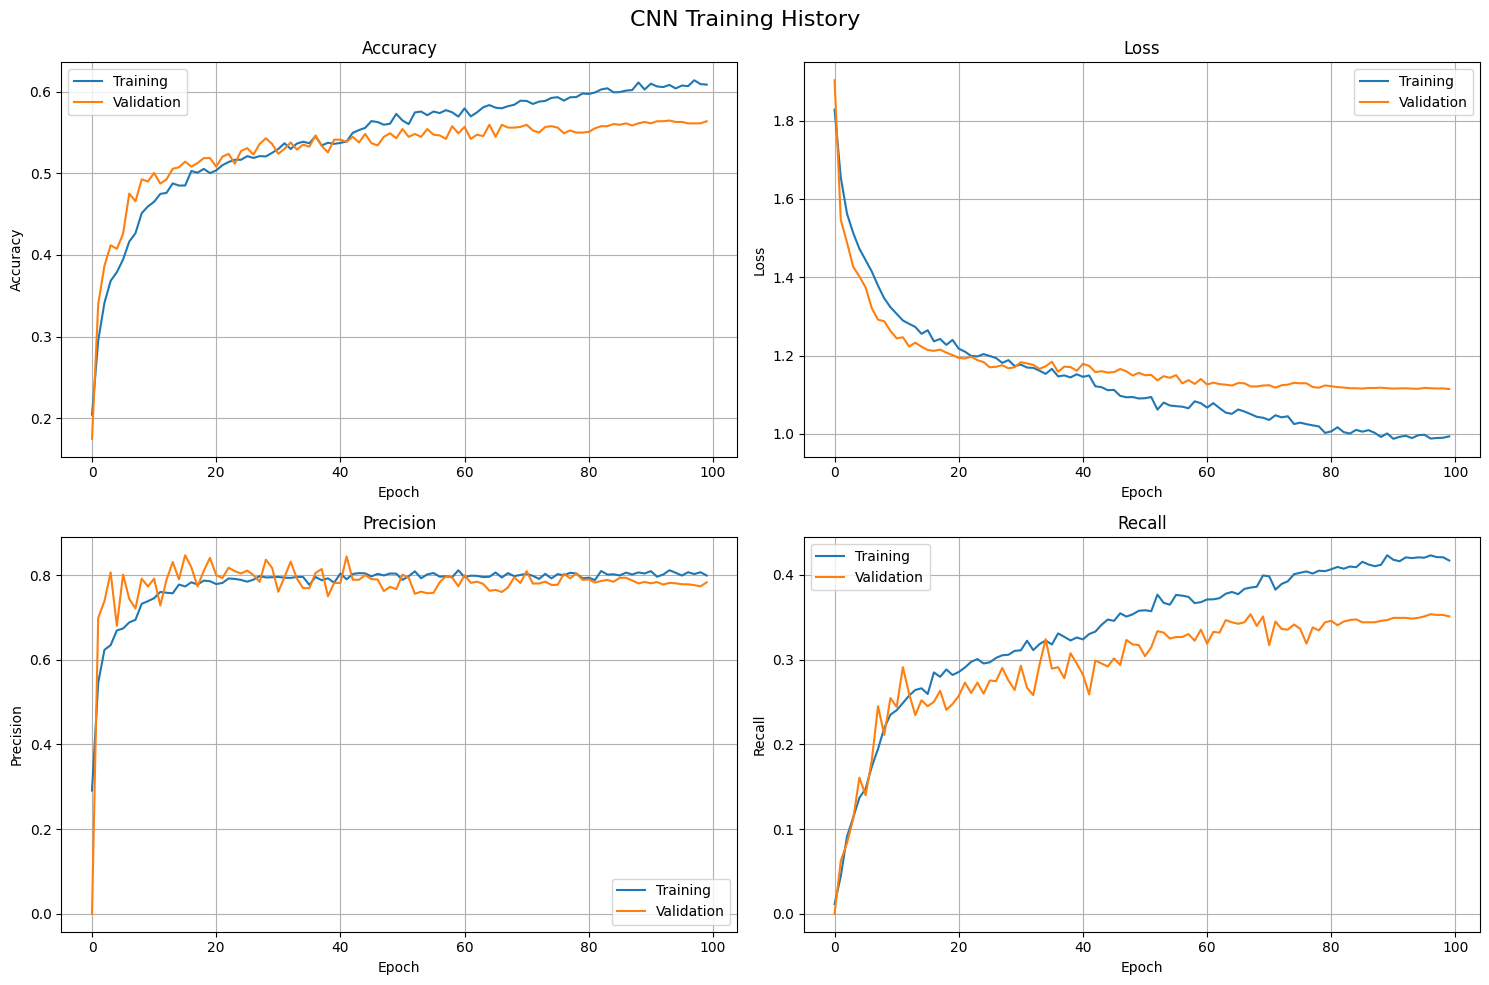

72/72 [==============================] - 0s 3ms/step


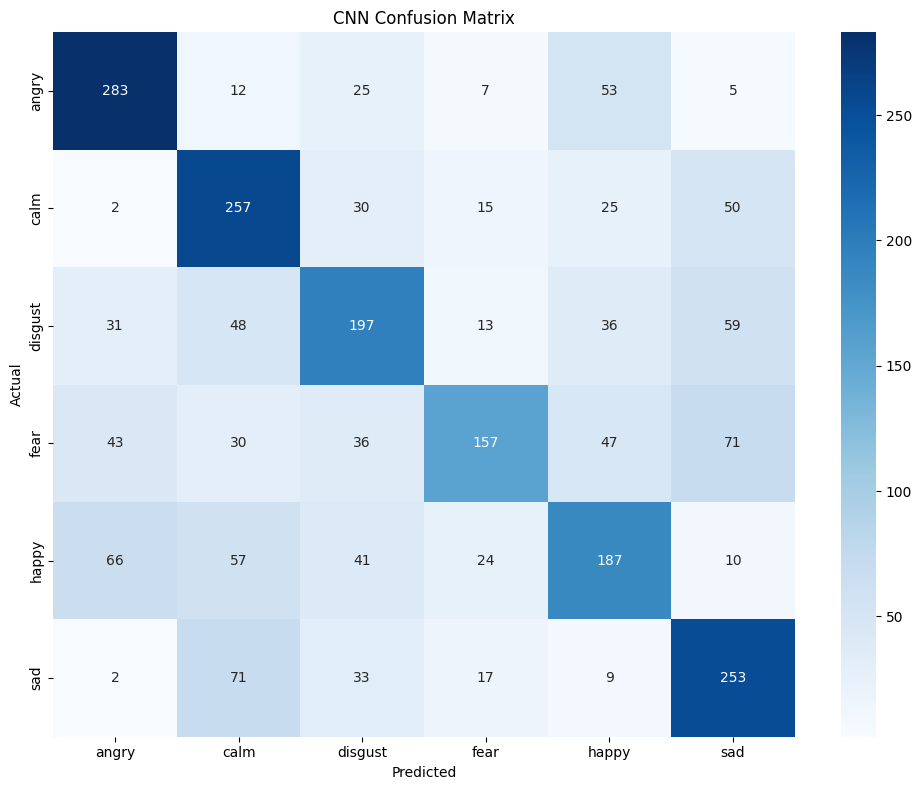

CNN Model Accuracy: 0.5795


In [ ]:
# 1. Choose your dataset (you have multiple options):
# Option A: Basic features without augmentation
X_without_augmentation, y_without_augmentation = X_basic_orig, y_orig

# Option B: Enhanced features without augmentation  
X_enhanced_without_augmentation, y_enhanced_without_augmentation = X_enhanced_orig, y_enhanced_orig

# Option C: Basic features with augmentation
X_with_augmentation, y_with_augmentation = X_basic_aug, y_aug

# Option D: Enhanced features with augmentation
X_enhanced_with_augmentation, y_enhanced_with_augmentation = X_enhanced_aug, y_enhanced_aug

# Choose ONE dataset to work with (uncomment the one you want):
#X, y = X_without_augmentation, y_without_augmentation
# X, y = X_enhanced_without_augmentation, y_enhanced_without_augmentation
# X, y = X_with_augmentation, y_with_augmentation
X, y = X_enhanced_with_augmentation, y_enhanced_with_augmentation

# Prepare the chosen dataset
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(X, y)

# Get input shape and number of classes from the prepared data
input_shape = (X_train.shape[1],)  # Shape of features
num_classes = y_train.shape[1] if len(y_train.shape) > 1 else len(np.unique(y_train))

# Train your CNN model - now passing all required parameters
cnn_model, cnn_history, cnn_acc = train_individual_model(
    X_train, X_val, X_test, y_train, y_val, y_test,
    input_shape, num_classes, model_type='CNN'
)

# Optional: Save all results
# save_results()

print(f"CNN Model Accuracy: {cnn_acc:.4f}")

Preparing data for training...
Training set: (8056, 166)
Validation set: (1151, 166)
Test set: (2302, 166)
Number of classes: 6
Classes: ['angry' 'calm' 'disgust' 'fear' 'happy' 'sad']
Training LSTM model...

Training LSTM Model

Model Architecture:
Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_11 (Reshape)        (None, 166, 1)            0         
                                                                 
 lstm_3 (LSTM)               (None, 166, 128)          66560     
                                                                 
 batch_normalization_33 (Ba  (None, 166, 128)          512       
 tchNormalization)                                               
                                                                 
 lstm_4 (LSTM)               (None, 166, 64)           49408     
                                                                 
 batch_nor

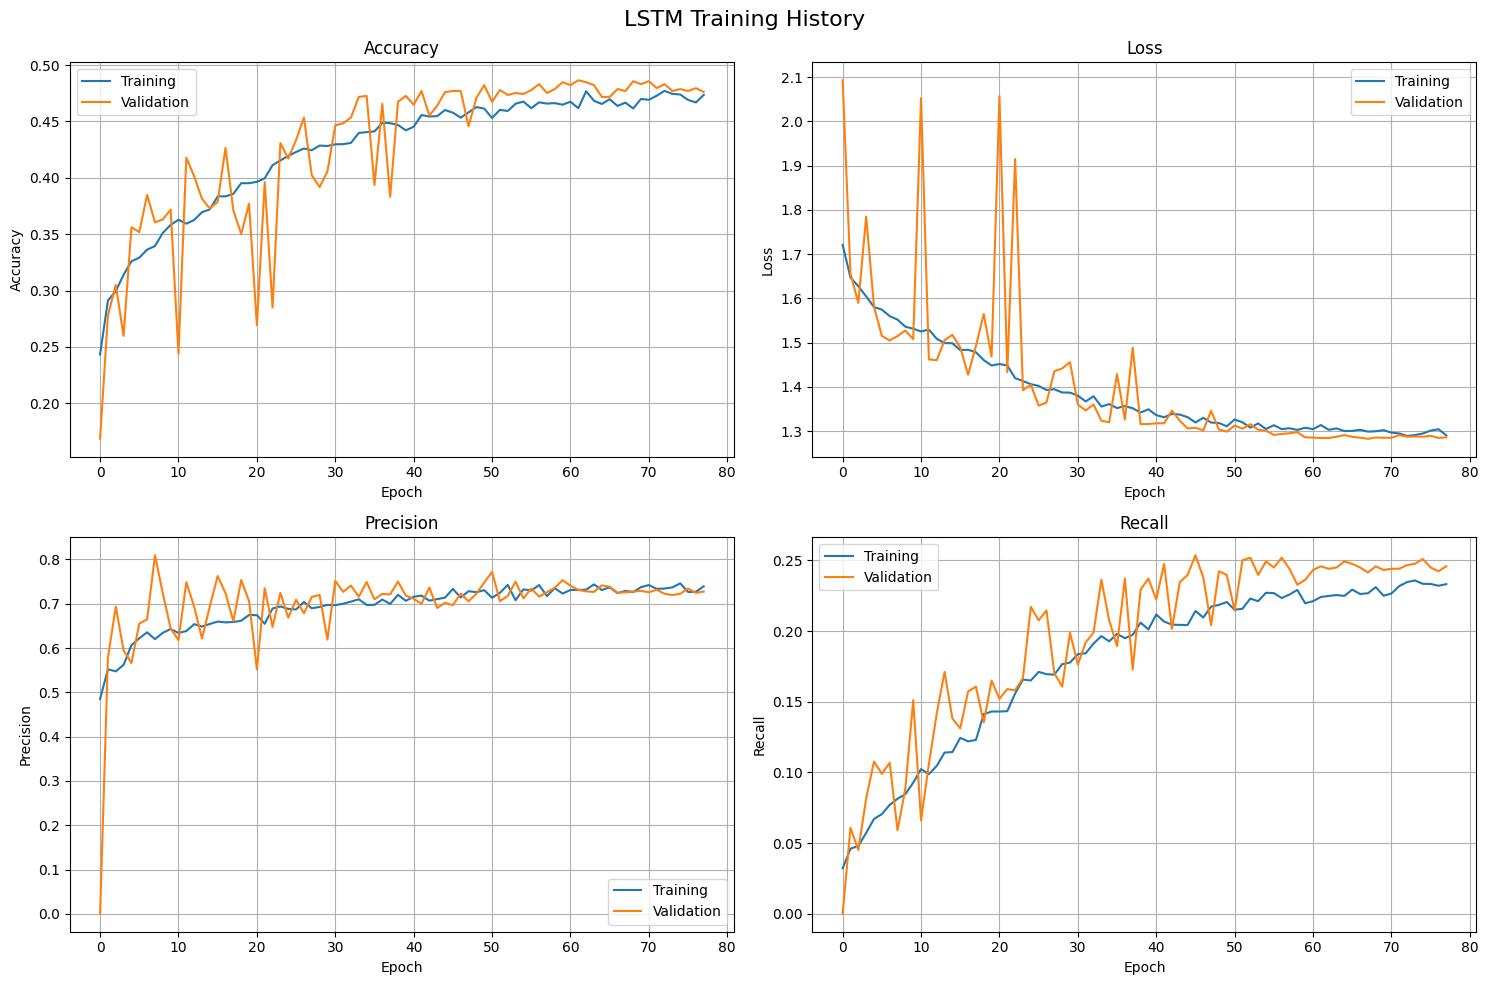

72/72 [==============================] - 3s 44ms/step


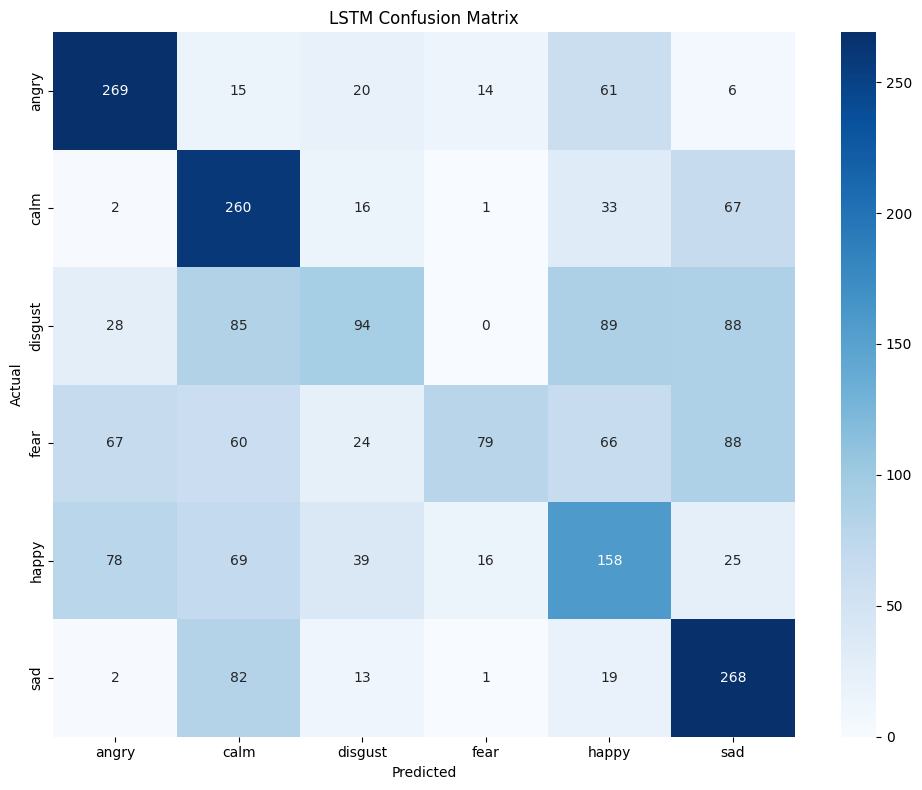

LSTM Model Accuracy: 0.4900


In [ ]:
# 1. Choose your dataset (you have multiple options):
# Option A: Basic features without augmentation
X_without_augmentation, y_without_augmentation = X_basic_orig, y_orig

# Option B: Enhanced features without augmentation  
X_enhanced_without_augmentation, y_enhanced_without_augmentation = X_enhanced_orig, y_enhanced_orig

# Option C: Basic features with augmentation
X_with_augmentation, y_with_augmentation = X_basic_aug, y_aug

# Option D: Enhanced features with augmentation
X_enhanced_with_augmentation, y_enhanced_with_augmentation = X_enhanced_aug, y_enhanced_aug

# Choose ONE dataset to work with (uncomment the one you want):
X, y = X_without_augmentation, y_without_augmentation
# X, y = X_enhanced_without_augmentation, y_enhanced_without_augmentation
# X, y = X_with_augmentation, y_with_augmentation
#X, y = X_enhanced_with_augmentation, y_enhanced_with_augmentation

# Prepare the chosen dataset
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(X, y)

# Get input shape and number of classes from the prepared data
input_shape = (X_train.shape[1],)  # Shape of features
num_classes = y_train.shape[1] if len(y_train.shape) > 1 else len(np.unique(y_train))

# Train your LSTM model - now passing all required parameters
lstm_model, lstm_history, lstm_acc = train_individual_model(
    X_train, X_val, X_test, y_train, y_val, y_test,
    input_shape, num_classes, model_type='LSTM'
)

# Optional: Save all results
# save_results()

print(f"LSTM Model Accuracy: {lstm_acc:.4f}")

In [ ]:
# 1. Choose your dataset (you have multiple options):
# Option A: Basic features without augmentation
X_without_augmentation, y_without_augmentation = X_basic_orig, y_orig

# Option B: Enhanced features without augmentation  
X_enhanced_without_augmentation, y_enhanced_without_augmentation = X_enhanced_orig, y_enhanced_orig

# Option C: Basic features with augmentation
X_with_augmentation, y_with_augmentation = X_basic_aug, y_aug

# Option D: Enhanced features with augmentation
X_enhanced_with_augmentation, y_enhanced_with_augmentation = X_enhanced_aug, y_enhanced_aug

# Choose ONE dataset to work with (uncomment the one you want):
X, y = X_without_augmentation, y_without_augmentation
# X, y = X_enhanced_without_augmentation, y_enhanced_without_augmentation
# X, y = X_with_augmentation, y_with_augmentation
#X, y = X_enhanced_with_augmentation, y_enhanced_with_augmentation

# Prepare the chosen dataset
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(X, y)

# Get input shape and number of classes from the prepared data
input_shape = (X_train.shape[1],)  # Shape of features
num_classes = y_train.shape[1] if len(y_train.shape) > 1 else len(np.unique(y_train))

# Train your LSTM model - now passing all required parameters
lstm_model, lstm_history, lstm_acc = train_individual_model(
    X_train, X_val, X_test, y_train, y_val, y_test,
    input_shape, num_classes, model_type='RESIDUALCNN'
)

# Optional: Save all results
# save_results()

print(f"LSTM Model Accuracy: {lstm_acc:.4f}")

Preparing data for training...
Training set: (8056, 166)
Validation set: (1151, 166)
Test set: (2302, 166)
Number of classes: 6
Classes: ['angry' 'calm' 'disgust' 'fear' 'happy' 'sad']
Training RESIDUALCNN model...

Training RESIDUALCNN Model

Model Architecture:
Model: "RESIDUALCNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 166)]                0         []                            
                                                                                                  
 reshape_15 (Reshape)        (None, 166, 1)               0         ['input_2[0][0]']             
                                                                                                  
 conv1d_50 (Conv1D)          (None, 166, 64)              1024      ['reshape_15[0][0]']          
                      

KeyboardInterrupt: 